## Análisis Exploratorio de Datos


Es menester recordar que el presente trabajo tiene un enfoque de análisis estratégico respecto a los datos de los establecimientos gastronómicos del Estado de California, con el objeto de obtener insights que permitan a los potenciales clientes de EPICUREAN Data Solutions contar con la información necesaria para tomar decisiones de índole empresarial, como ser, potenciales inversiones y oportunidades de crecimiento.
Para garantizar que se proporcionen datos pertinentes y útiles para la toma de esas decisiones estratégicas, es fundamental considerar el potencial y contundencia de los datos sobre los que se impulsará el proyecto.

En el presente documento, se detalla paso por paso los procedimientos realizados para llevar adelante el análisis propuesto, el que se vale fundamentalmente de metadatos de diferentes locales gastronómicos del Estado de California, y reseñas de diferentes usuarios sobre los mismos.

En el *procedimiento de ETL* se ha realizado la carga y corrección de datos, revisando los formatos, los valores nulos y valores faltantes. También se ha realizado una limpieza de cadenas de texto, corregido los formatos erróneos, y **manejado los valores duplicados** Además, se ha hecho una inspección preliminar, para determinar qué datos podían ser de interés para este informe.

En esta nueva instancia, se procederá a un análisis de los datos seleccionadas por su relevancia, con mayor alcance que el análisis preliminar. Se intentará identificar patrones, outliers, comportamientos de los datos y su implicancia en el sector Gastronómico en el Estado de California.

In [35]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

#importamos las galerias necesarias

Procedemos a analizar, en primer lugar, la información disponible sobre locales gastronómicos del Estado de California.

In [6]:
df_metadatos = pd.read_parquet(r'C:\Users\GASTON\Desktop\PROYECTO FINAL\DATA\locales_google.parquet')
df_metadatos.head(3)

,gmap_id,name,address,latitude,longitude,category,avg_rating,num_of_reviews,state,relative_results,Service options,clasificacion,address_depurada,city,county
2,0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",34.058092,-118.292130,Korean restaurant,4.4,18,Open ⋅ Closes 6PM,"0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c...","Takeout, Dine-in, Delivery",Dining Venue,761 S Vermont Ave,Los Angeles,Acton
6,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,Vons Chicken,"Vons Chicken, 12740 La Mirada Blvd, La Mirada,...",33.916402,-118.010855,Restaurant,4.5,18,Open ⋅ Closes 9:30PM,Sin resultados vinculados,"Outdoor seating, Curbside pickup, No-contact d...",Dining Venue,12740 La Mirada Blvd,La Mirada,Acton
761,0x80c2baf50d29bf63:0x5bd904b842b9fcc,La Potranca,"La Potranca, 12821 Venice Blvd., Los Angeles, ...",34.000181,-118.441249,Restaurant,4.2,13,Closed ⋅ Opens 10AM,"0x80c2bac345536273:0x8b015c3512788465, 0x80c2c...","Dine-in, Delivery",Dining Venue,12821 Venice Blvd.,Los Angeles,Acton


In [7]:
df_metadatos.columns

Index(['gmap_id', 'name', 'address', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'state', 'relative_results',
       'Service options', 'clasificacion', 'address_depurada', 'city',
       'county'],
      dtype='object')

Comenzando con el análisis, observamos que cada establecimiento tiene su clave identificadora (gmap_id) que permite conectarse con las reseñas obtenidas (en la tabla 'reviews' que se analizará posteriormente).
En el proceso de ETL se ha extraído información de gran relevancia geográfica, ya que, sobre la base de su dirección, se extrajo la ciudad y se asignó su Condado.

In [13]:
ciudades = df_metadatos['city'].unique().size
condados = df_metadatos['county'].unique().size
print(f'El total de ciudades con establecimientos gastronómicos es de {ciudades}, mientras que la cantidad total de condados es {condados}')

El total de ciudades con establecimientos gastronómicos es de 683, mientras que la cantidad total de condados es 58


Para continuar analizando nuestra muestra representativa, podemos evaluar la cantidad de establecimientos calificados.

In [14]:
establecimientos = df_metadatos['gmap_id'].unique().size
print(f'La cantidad total de establecimientos con reseña en el Estado de California son {establecimientos}')

La cantidad total de establecimientos con reseña en el Estado de California son 7811


Procedemos, entonces, a correlacionar estas variables/categorias. Para ello, podemos sacar un ranking de los condados con más establecimientos calificados.

In [15]:
# Top 15 de condados con más establecimientos (conteo de gmap_id)
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Mostrar resultados
print("Top 15 condados con más establecimientos:")
print(top_15_condados)

Top 15 condados con más establecimientos:
            county  num_establecimientos
0            Acton                  1817
29          Orange                   736
36       San Diego                   550
18     Los Angeles                   496
1          Alameda                   397
42     Santa Clara                   382
37   San Francisco                   341
32       Riverside                   314
35  San Bernardino                   299
9           Fresno                   213
33      Sacramento                   212
6     Contra Costa                   185
55         Ventura                   158
40       San Mateo                   152
48          Sonoma                   139


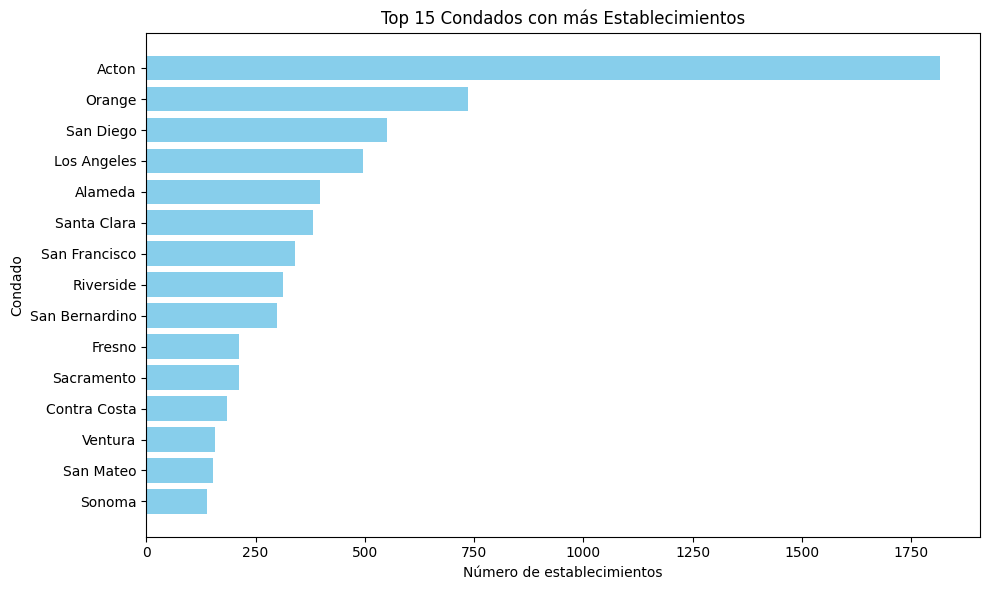

In [16]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.barh(top_15_condados['county'], top_15_condados['num_establecimientos'], color='skyblue')
plt.xlabel('Número de establecimientos')
plt.ylabel('Condado')
plt.title('Top 15 Condados con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje y para que el condado con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Veamos si hay cambios cuando realizamos el análisis por Ciudad, y no por condado.

In [18]:
# Top 15 de Ciudades con más establecimientos (conteo de gmap_id)
top_15_ciudades = df_metadatos.groupby('city')['gmap_id'].count().reset_index()
top_15_ciudades = top_15_ciudades.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_ciudades = top_15_ciudades.sort_values(by='num_establecimientos', ascending=False).head(15)


# Mostrar resultados
print("Top 15 Ciudades con más establecimientos:")
print(top_15_ciudades)

Top 15 Ciudades con más establecimientos:
              city  num_establecimientos
328    Los Angeles                   653
525  San Francisco                   341
522      San Diego                   244
528       San Jose                   176
208         Fresno                   139
513     Sacramento                   122
406        Oakland                   104
323     Long Beach                    90
543      Santa Ana                    90
35     Bakersfield                    79
499      Riverside                    73
14         Anaheim                    67
592       Stockton                    64
212   Garden Grove                    58
422         Oxnard                    55


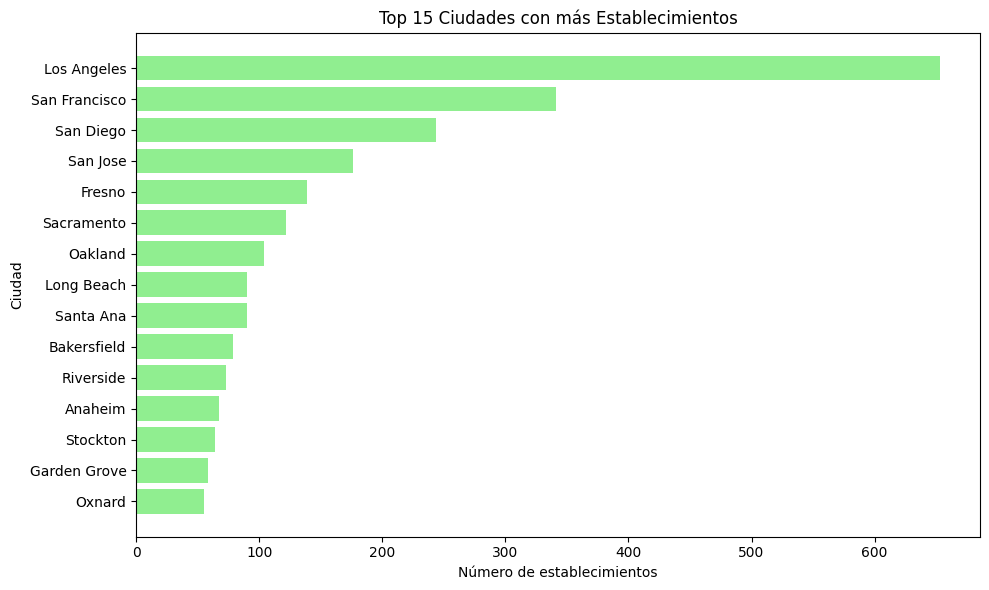

In [19]:
# Crear el histograma para el top 15 de ciudades con más establecimientos
plt.figure(figsize=(10, 6))
plt.barh(top_15_ciudades['city'], top_15_ciudades['num_establecimientos'], color='lightgreen')
plt.xlabel('Número de establecimientos')
plt.ylabel('Ciudad')
plt.title('Top 15 Ciudades con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje Y para que la ciudad con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Aquí hemos identificado que se encuentra erróneamente catalogado como "Acton" el Condado de Los Ángeles. Lo cambiaremos aquí, y se modifca el código para evitar este error en lo sucesivo en el proceso de ETL.

In [20]:
df_metadatos['county'] = df_metadatos['county'].replace('Acton', 'Los Angeles')

Ahora sí, podemos volver a realizar el análisis por Condados, para tener valores correctos

In [21]:
# Top 15 de condados con más establecimientos (conteo de gmap_id)
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Mostrar resultados
print("Top 15 condados con más establecimientos:")
print(top_15_condados)

Top 15 condados con más establecimientos:
            county  num_establecimientos
17     Los Angeles                  2313
28          Orange                   736
35       San Diego                   550
0          Alameda                   397
41     Santa Clara                   382
36   San Francisco                   341
31       Riverside                   314
34  San Bernardino                   299
8           Fresno                   213
32      Sacramento                   212
5     Contra Costa                   185
54         Ventura                   158
39       San Mateo                   152
47          Sonoma                   139
13            Kern                   137


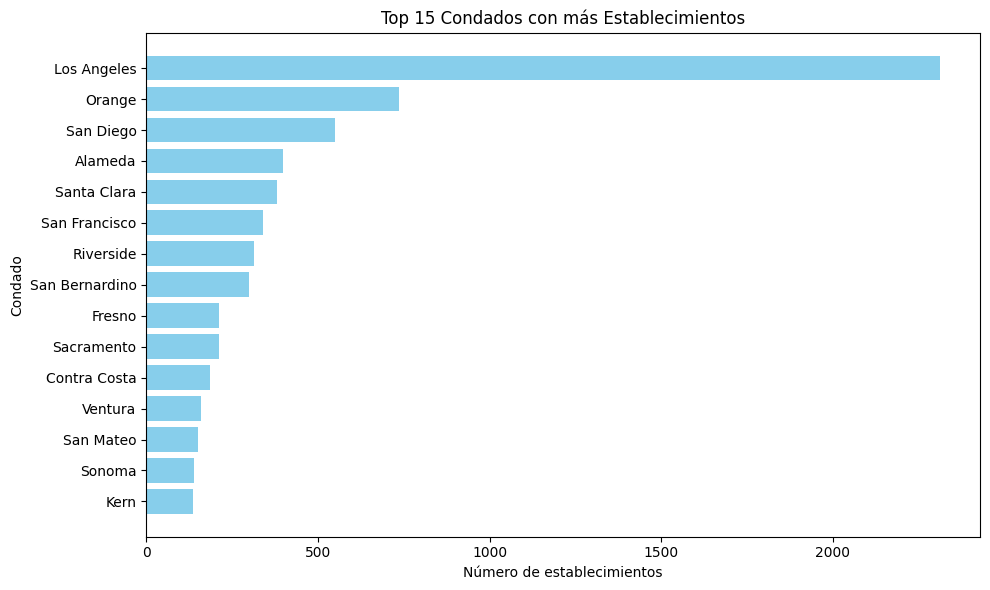

In [22]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.barh(top_15_condados['county'], top_15_condados['num_establecimientos'], color='skyblue')
plt.xlabel('Número de establecimientos')
plt.ylabel('Condado')
plt.title('Top 15 Condados con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje y para que el condado con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los datos aquieren mucho más sentido: Los Angeles tienen un enorme atractivo turístico, sin dejar de ser una localidad ampliamente industrializada, con gran desarrollo comercial. Veamos ahora cuáles son las ciudades principales de esos condados.

In [23]:
# Obtener el top 15 de condados con más establecimientos
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Crear un DataFrame para almacenar los resultados
resultados_top_ciudades = []

# Iterar sobre cada condado en el top 15
for condado in top_15_condados['county']:
    # Filtrar por el condado actual
    ciudades_en_condado = df_metadatos[df_metadatos['county'] == condado]
    
    # Obtener el top 3 de ciudades con más establecimientos
    top_ciudades = ciudades_en_condado.groupby('city')['gmap_id'].count().reset_index()
    top_ciudades = top_ciudades.rename(columns={'gmap_id': 'num_establecimientos'})
    top_ciudades = top_ciudades.sort_values(by='num_establecimientos', ascending=False).head(3)
    
    # Añadir el condado como columna en el resultado
    top_ciudades['county'] = condado
    
    # Agregar al resultado
    resultados_top_ciudades.append(top_ciudades)

# Concatenar todos los resultados en un solo DataFrame
df_resultados = pd.concat(resultados_top_ciudades, ignore_index=True)

# Mostrar resultados
print(df_resultados)

                city  num_establecimientos          county
0        Los Angeles                   653     Los Angeles
1         Long Beach                    90     Los Angeles
2           Glendale                    45     Los Angeles
3          Santa Ana                    90          Orange
4            Anaheim                    67          Orange
5       Garden Grove                    58          Orange
6          San Diego                   244       San Diego
7        Chula Vista                    40       San Diego
8           El Cajon                    25       San Diego
9            Oakland                   104         Alameda
10          Berkeley                    46         Alameda
11           Fremont                    45         Alameda
12          San Jose                   176     Santa Clara
13       Santa Clara                    32     Santa Clara
14         Sunnyvale                    27     Santa Clara
15     San Francisco                   341   San Francis

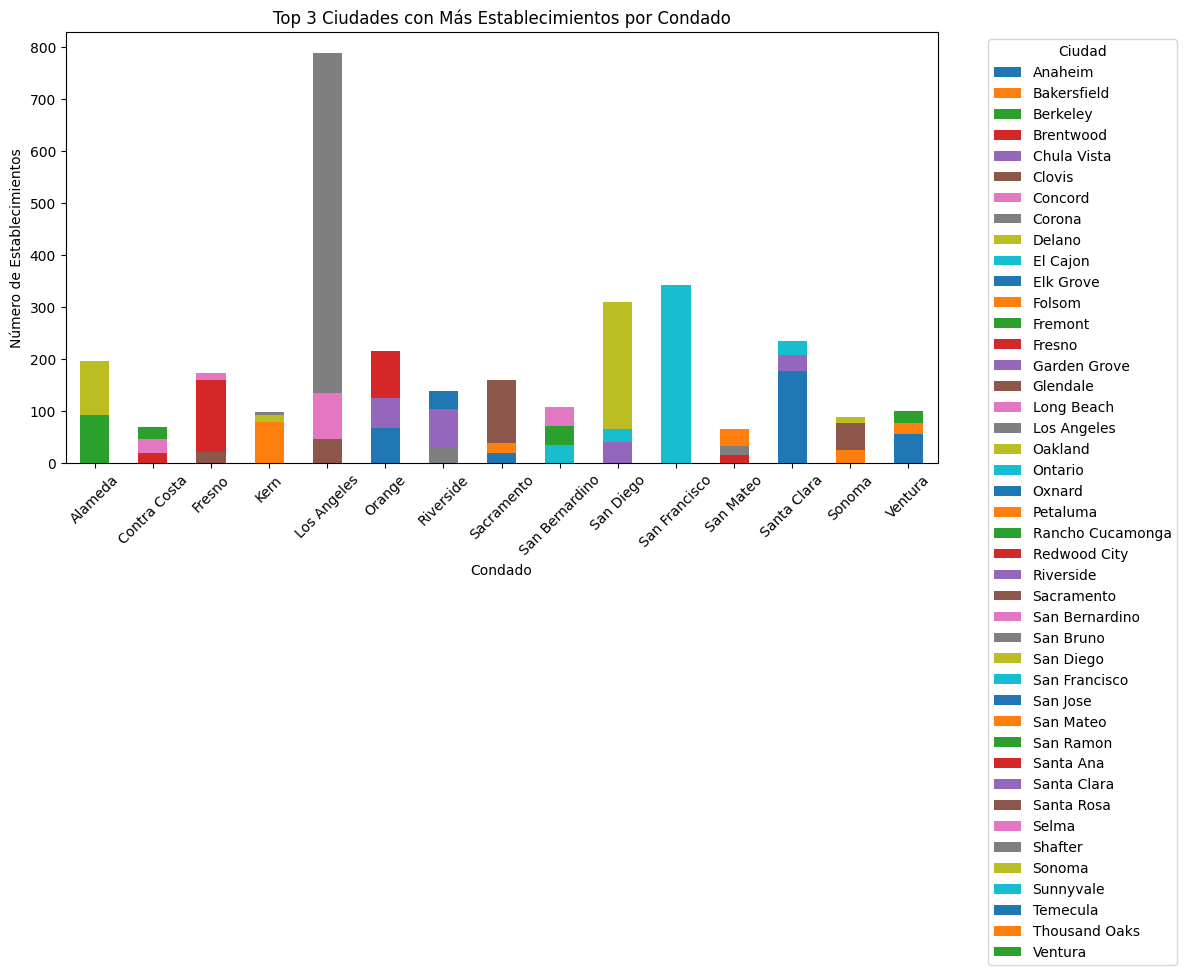

In [24]:
# Crear un DataFrame para las ciudades en formato adecuado para gráfico
df_resultados_pivot = df_resultados.pivot(index='county', columns='city', values='num_establecimientos').fillna(0)

# Crear el gráfico de columnas apiladas
plt.figure(figsize=(12, 8))
df_resultados_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), color=plt.cm.tab10.colors)

plt.title('Top 3 Ciudades con Más Establecimientos por Condado')
plt.xlabel('Condado')
plt.ylabel('Número de Establecimientos')
plt.xticks(rotation=45)
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

La distribución por ciudades, condados y la cantidad de establecimientos sirve para detectar algunos indicadores, a primera vista, dignos de ser analizados:

- Densidad Poblacional: Un mayor número de establecimientos suele correlacionarse con una población más densa, lo que significa que hay más consumidores disponibles para los negocios.

- Actividad Económica: Una alta concentración de establecimientos puede reflejar una economía local activa, con diversas oportunidades comerciales y una buena infraestructura de servicios.

- Atracción Turística: Ciudades o condados con un gran número de establecimientos, especialmente en el sector de servicios, pueden ser destinos turísticos importantes, ofreciendo restaurantes, tiendas, hoteles y actividades recreativas.

- Acceso a Recursos y Servicios: Un mayor número de establecimientos puede indicar un mejor acceso a bienes y servicios para los residentes, lo que puede mejorar la calidad de vida.

- Competencia y Diversidad: Un alto número de negocios en una área también sugiere un mercado competitivo, lo que puede beneficiar a los consumidores a través de precios más bajos y una mayor diversidad de opciones.

- Inversión y Desarrollo: Un crecimiento en el número de establecimientos puede ser indicativo de inversión en la infraestructura local y desarrollo urbano, lo que puede ser positivo para la economía de la región. 

# Categorías de los Establecimientos

Corresponde adentrarnos en el análisis de las diferentes categorías, y luego podremos realizar un análisis cruzada para obtener mejores conclusiones.

In [26]:
cant_categorias = df_metadatos['category'].unique().size
print(f'La muestra representativa presenta un total de {cant_categorias} categorías diferentes')

La muestra representativa presenta un total de 2212 categorías diferentes


In [31]:
categorias = df_metadatos['category'].unique()
categorias

array(['Korean restaurant', 'Restaurant',
       'Convenience store, ATM, Coffee shop, Coffee store, Public bathroom, Snack bar, Soft drinks shop',
       ...,
       'Pizza takeaway, American restaurant, Italian restaurant, Pizza restaurant, Vegetarian restaurant',
       'Bagel shop, Coffee shop',
       'American restaurant, Brunch restaurant, Cocktail bar, Restaurant'],
      dtype=object)

Tenemos más de 2000 categorías, lo que hace difícil un análisis a secas.

In [32]:
# Contar el número de locales por categoría usando gmap_id
conteo_categorias = df_metadatos.groupby('category')['gmap_id'].count().reset_index()

# Renombrar las columnas para mayor claridad
conteo_categorias.columns = ['category', 'num_locales']

# Ordenar las categorías por el número de locales en orden descendente
conteo_categorias = conteo_categorias.sort_values(by='num_locales', ascending=False)

# Mostrar las categorías ordenadas
print(conteo_categorias)

                                               category  num_locales
1685                                         Restaurant          948
1332                                 Mexican restaurant          553
1930  Sandwich shop, Caterer, Fast food restaurant, ...          348
112                                              Bakery          274
333                                                Cafe          235
...                                                 ...          ...
781   Ecuadorian restaurant, Bar, Family restaurant,...            1
780   Eclectic restaurant, Caterer, Deli, Restaurant...            1
779                             East African restaurant            1
778   Dumpling restaurant, Chinese restaurant, Chine...            1
2211  Wok restaurant, Asian fusion restaurant, Asian...            1

[2212 rows x 2 columns]


Analicemos las categorías principales, con más número de locales.

In [33]:
# Obtener el top 20 de categorías
top_20_categorias = conteo_categorias.head(20)

# Mostrar el top 20 de categorías
print(top_20_categorias)

                                               category  num_locales
1685                                         Restaurant          948
1332                                 Mexican restaurant          553
1930  Sandwich shop, Caterer, Fast food restaurant, ...          348
112                                              Bakery          274
333                                                Cafe          235
568                                         Coffee shop          197
500                                  Chinese restaurant          171
1572                                   Pizza restaurant          123
2164                              Vietnamese restaurant           79
2066                                    Taco restaurant           76
592   Coffee shop, Breakfast restaurant, Cafe, Coffe...           74
1168                                Japanese restaurant           69
1950                                 Seafood restaurant           64
606       Coffee shop, Cafe, Coffe

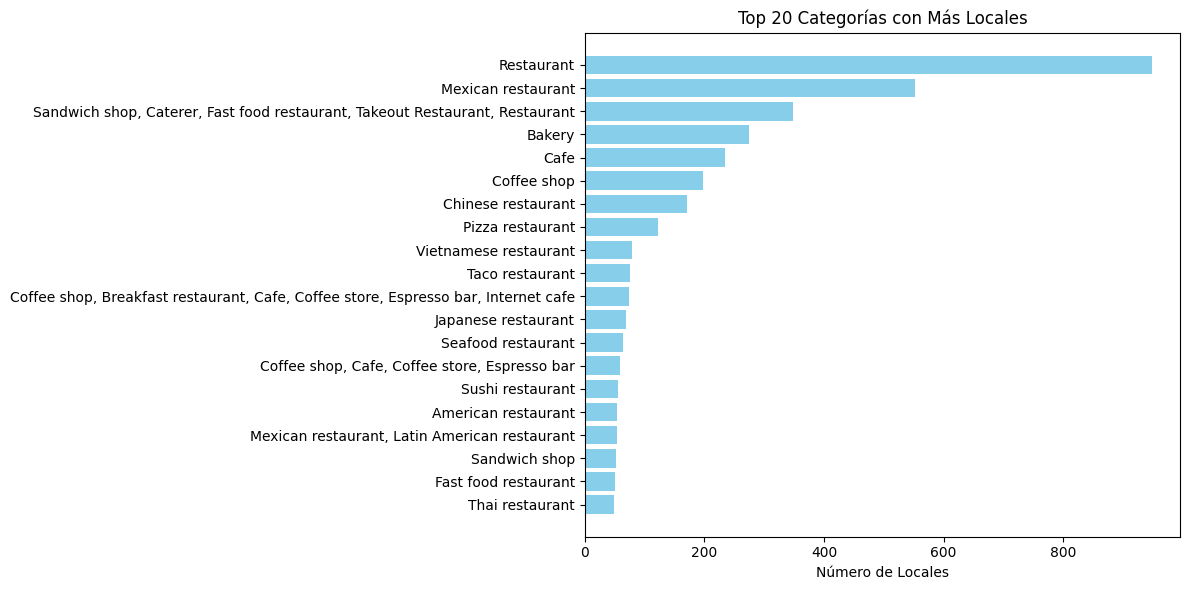

In [34]:
import matplotlib.pyplot as plt

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.barh(top_20_categorias['category'], top_20_categorias['num_locales'], color='skyblue')
plt.xlabel('Número de Locales')
plt.title('Top 20 Categorías con Más Locales')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la categoría con más locales en la parte superior
plt.tight_layout()

# Mostrar el gráfico
plt.show()


La categoría principal es 'Restaurant', y da cuenta de un establecimiento con servicio de atención en el local, aunque no exclusivamente. Veamos hora las palabras que más se repiten dentro de estos establecimientos.

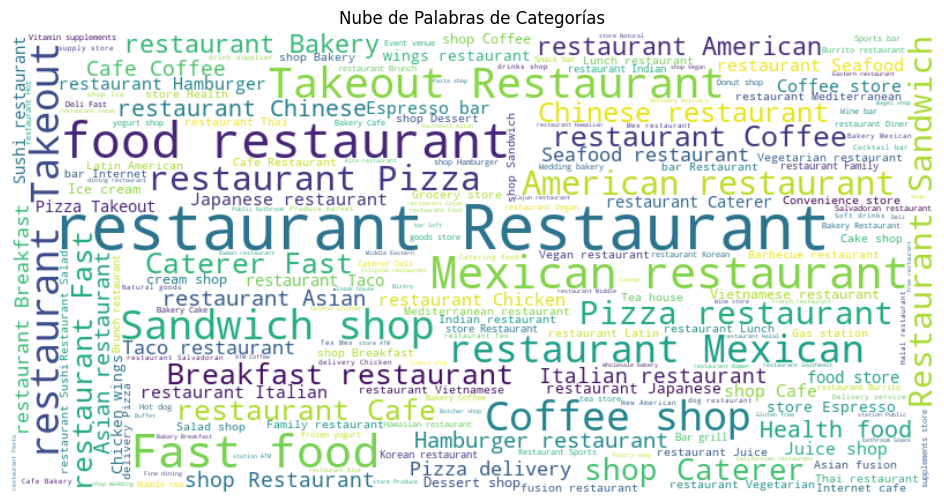

In [36]:
# Unir todas las categorías en un solo string
text = ' '.join(df_metadatos['category'].astype(str))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras de Categorías')
plt.show()


Se pueden analizar en profundidad los servicios que se indican en la categoría del establecimiento.

In [38]:
# Lista de palabras clave para filtrar
palabras_clave = ['restaurant', 'delivery', 'takeout', 'pickup']

# Filtrar las categorías que contienen alguna de las palabras clave (sin distinción entre mayúsculas y minúsculas)
filtro_categorias = df_metadatos['category'].str.contains('|'.join(palabras_clave), case=False)

# Contar el número de categorías filtradas
conteo_categorias_filtradas = df_metadatos[filtro_categorias]['category'].nunique()

# Mostrar el conteo
print(f"De todos los registros, un total de {conteo_categorias_filtradas} indican el servicio.")


De todos los registros, un total de 1864 indican el servicio.


In [40]:
# Inicializar un diccionario para contar las apariciones de cada palabra clave
conteo_palabras = {palabra: 0 for palabra in palabras_clave}

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Contar las apariciones de cada palabra clave en las categorías
for palabra in palabras_clave:
    conteo_palabras[palabra] = categorias_bajas.str.count(palabra).sum()

# Mostrar los resultados
for palabra, conteo in conteo_palabras.items():
    print(f"La palabra '{palabra}' aparece {conteo} veces en las categorías.")


La palabra 'restaurant' aparece 11881 veces en las categorías.
La palabra 'delivery' aparece 451 veces en las categorías.
La palabra 'takeout' aparece 973 veces en las categorías.
La palabra 'pickup' aparece 0 veces en las categorías.


In [41]:
# Inicializar un diccionario para contar los registros por palabra clave
conteo_registros = {palabra: 0 for palabra in palabras_clave}

# Contar registros donde cada palabra clave aparece al menos una vez
for palabra in palabras_clave:
    conteo_registros[palabra] = categorias_bajas.str.contains(palabra).sum()

# Mostrar los resultados
for palabra, conteo in conteo_registros.items():
    print(f"La palabra '{palabra}' aparece en {conteo} registros de categorías.")


La palabra 'restaurant' aparece en 6379 registros de categorías.
La palabra 'delivery' aparece en 391 registros de categorías.
La palabra 'takeout' aparece en 919 registros de categorías.
La palabra 'pickup' aparece en 0 registros de categorías.


Ahora realizaremos ese análisis, respecto a los tipos de comida ofrecidos

In [42]:
# Definir los grupos de palabras clave
grupos_palabras = {
    'cafe_coffee_espresso': ['cafe', 'coffee', 'espresso'],
    'pizza': ['pizza'],
    'japanese': ['japanese'],
    'sandwich': ['sandwich'],
    'taco_mexican': ['taco', 'mexican'],
    'indian': ['indian'],
    'chinese': ['chinese'],
    'vegetarian': ['vegetarian'],
    'chicken': ['chicken'],
    'burger_hamburger': ['burger', 'hamburger'],
    'salad': ['salad'],
    'soup': ['soup'],
    'dessert': ['dessert']
}

# Inicializar un diccionario para contar los registros por grupo de palabras clave
conteo_registros_grupos = {grupo: 0 for grupo in grupos_palabras.keys()}

# Convertir la columna 'category' a minúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Contar registros donde cada grupo de palabras aparece al menos una vez
for grupo, palabras in grupos_palabras.items():
    # Crear un patrón para la búsqueda
    patron = '|'.join(palabras)
    conteo_registros_grupos[grupo] = categorias_bajas.str.contains(patron).sum()

# Mostrar los resultados
for grupo, conteo in conteo_registros_grupos.items():
    print(f"El grupo '{grupo}' aparece en {conteo} registros de categorías.")


El grupo 'cafe_coffee_espresso' aparece en 1251 registros de categorías.
El grupo 'pizza' aparece en 551 registros de categorías.
El grupo 'japanese' aparece en 187 registros de categorías.
El grupo 'sandwich' aparece en 771 registros de categorías.
El grupo 'taco_mexican' aparece en 1057 registros de categorías.
El grupo 'indian' aparece en 87 registros de categorías.
El grupo 'chinese' aparece en 351 registros de categorías.
El grupo 'vegetarian' aparece en 137 registros de categorías.
El grupo 'chicken' aparece en 268 registros de categorías.
El grupo 'burger_hamburger' aparece en 255 registros de categorías.
El grupo 'salad' aparece en 112 registros de categorías.
El grupo 'soup' aparece en 40 registros de categorías.
El grupo 'dessert' aparece en 174 registros de categorías.


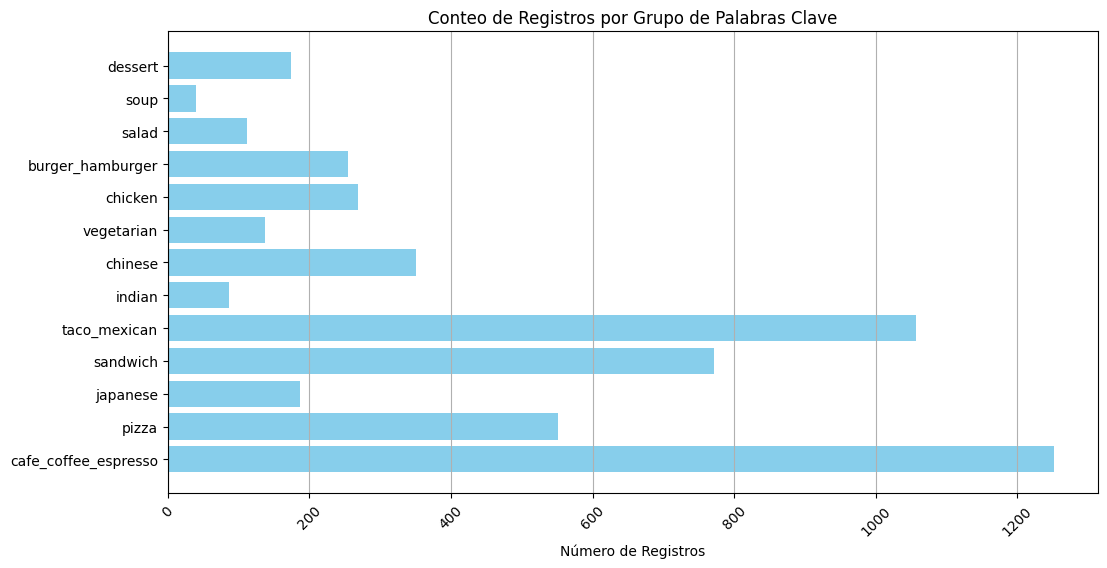

In [43]:
import matplotlib.pyplot as plt

# Crear listas para los nombres de los grupos y sus conteos
grupos = list(conteo_registros_grupos.keys())
conteos = list(conteo_registros_grupos.values())

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(grupos, conteos, color='skyblue')
plt.xlabel('Número de Registros')
plt.title('Conteo de Registros por Grupo de Palabras Clave')
plt.xticks(rotation=45)
plt.grid(axis='x')

# Mostrar el gráfico
plt.show()


Observemos si hay primacía de alguna ciudad sobre las preferencias.

In [44]:
# Inicializar un diccionario para almacenar los resultados
top_ciudades_por_grupo = {grupo: {} for grupo in grupos_palabras.keys()}

# Contar las ciudades para cada grupo de palabras clave
for grupo, palabras in grupos_palabras.items():
    patron = '|'.join(palabras)
    # Filtrar las ciudades que contienen alguna de las palabras del grupo
    ciudades_con_palabra = df_metadatos[categorias_bajas.str.contains(patron)]['city']
    # Contar las ocurrencias de cada ciudad
    conteo_ciudades = ciudades_con_palabra.value_counts().head(3)
    top_ciudades_por_grupo[grupo] = conteo_ciudades

# Mostrar los resultados
for grupo, conteo in top_ciudades_por_grupo.items():
    print(f"\nTop 3 ciudades para el grupo '{grupo}':")
    print(conteo)



Top 3 ciudades para el grupo 'cafe_coffee_espresso':
city
Los Angeles      90
San Francisco    88
San Diego        42
Name: count, dtype: int64

Top 3 ciudades para el grupo 'pizza':
city
Los Angeles    35
San Diego      12
Sacramento     12
Name: count, dtype: int64

Top 3 ciudades para el grupo 'japanese':
city
Los Angeles      18
San Francisco     8
Torrance          7
Name: count, dtype: int64

Top 3 ciudades para el grupo 'sandwich':
city
Los Angeles      39
San Diego        28
San Francisco    28
Name: count, dtype: int64

Top 3 ciudades para el grupo 'taco_mexican':
city
Los Angeles    99
Fresno         34
Santa Ana      26
Name: count, dtype: int64

Top 3 ciudades para el grupo 'indian':
city
Los Angeles      6
Sacramento       5
San Francisco    5
Name: count, dtype: int64

Top 3 ciudades para el grupo 'chinese':
city
Los Angeles    34
San Diego      13
San Jose       11
Name: count, dtype: int64

Top 3 ciudades para el grupo 'vegetarian':
city
Los Angeles      14
San Diego  

In [47]:
# Inicializar un diccionario para almacenar las preferencias por ciudad
preferencias_por_ciudad = {}

# Iterar sobre cada fila en el DataFrame de resultados
for _, fila in df_resultados.iterrows():
    ciudad = fila['city']
    condado = fila['county']
    
    # Filtrar las categorías de la ciudad
    categorias_ciudad = df_metadatos[df_metadatos['city'] == ciudad]['category']
    
    # Contar las palabras clave presentes en las categorías
    conteo_palabras = {}
    for grupo, palabras in grupos_palabras.items():
        patron = '|'.join(palabras)
        conteo_palabras[grupo] = categorias_ciudad.str.contains(patron, case=False, na=False).sum()
    
    # Almacenar el conteo de palabras en el diccionario de preferencias
    preferencias_por_ciudad[ciudad] = conteo_palabras

# Mostrar las preferencias por ciudad
for ciudad, conteo in preferencias_por_ciudad.items():
    print(f"\nPreferencias para la ciudad '{ciudad}':")
    for grupo, cantidad in conteo.items():
        print(f"  - {grupo}: {cantidad}")



Preferencias para la ciudad 'Los Angeles':
  - cafe_coffee_espresso: 90
  - pizza: 35
  - japanese: 18
  - sandwich: 39
  - taco_mexican: 99
  - indian: 6
  - chinese: 34
  - vegetarian: 14
  - chicken: 23
  - burger_hamburger: 20
  - salad: 16
  - soup: 5
  - dessert: 12

Preferencias para la ciudad 'Long Beach':
  - cafe_coffee_espresso: 12
  - pizza: 9
  - japanese: 1
  - sandwich: 9
  - taco_mexican: 13
  - indian: 0
  - chinese: 1
  - vegetarian: 0
  - chicken: 9
  - burger_hamburger: 2
  - salad: 2
  - soup: 0
  - dessert: 0

Preferencias para la ciudad 'Glendale':
  - cafe_coffee_espresso: 9
  - pizza: 8
  - japanese: 2
  - sandwich: 5
  - taco_mexican: 0
  - indian: 0
  - chinese: 0
  - vegetarian: 2
  - chicken: 2
  - burger_hamburger: 2
  - salad: 1
  - soup: 0
  - dessert: 1

Preferencias para la ciudad 'Santa Ana':
  - cafe_coffee_espresso: 13
  - pizza: 2
  - japanese: 1
  - sandwich: 6
  - taco_mexican: 26
  - indian: 0
  - chinese: 2
  - vegetarian: 0
  - chicken: 4
  -

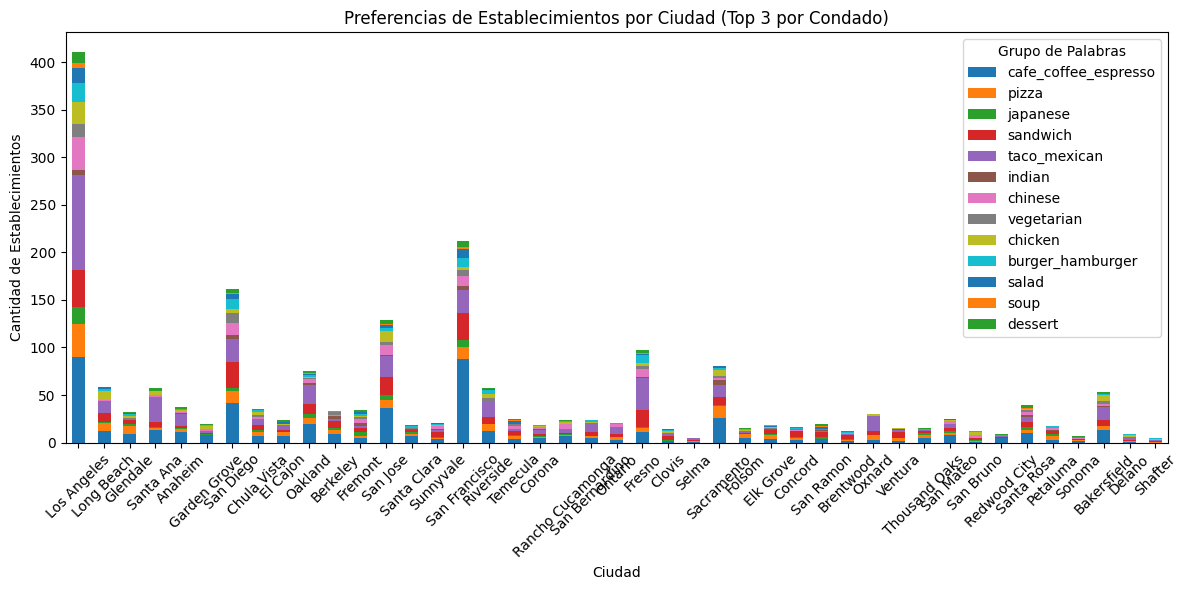

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el diccionario de preferencias a un DataFrame
preferencias_df = pd.DataFrame(preferencias_por_ciudad).T

# Resetear el índice para tener las ciudades como una columna
preferencias_df.reset_index(inplace=True)
preferencias_df.rename(columns={'index': 'city'}, inplace=True)

# Crear un gráfico de barras para cada grupo de palabras
preferencias_df.set_index('city').plot(kind='bar', stacked=True, figsize=(12, 6))

# Personalizar el gráfico
plt.title('Preferencias de Establecimientos por Ciudad (Top 3 por Condado)')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de Establecimientos')
plt.legend(title='Grupo de Palabras')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Los informes anteriores me traen a este gráfico, en el que podemos visualizar las preferencias de cada una de las principales ciudades por condados. Estas preferencias permiten identificar ciertas tendencias en el consumo.
Podemos ver, a primera vista, que ciertas ciudades como Los Angeles, San Franciso o Santa Clara tienen una gran cantidad de establecimientos con 'ensaladas' (salad) o 'sopas' (soup): aparentemente, en esas ciudades puede haber un gran mercado dispuesto al consumo saludable. También es alta la cantidad de locales de 'sandwichs' y 'café', lo que implica un consumo habitual de los mismos en centros urbanos o industriales.
La presencia de múltiples establecimientos en una categoría específica puede indicar un mercado competitivo, lo que a su vez puede beneficiar a los consumidores con mejores precios y servicios.
Identificar las preferencias menos satisfechas o las categorías en crecimiento puede ofrecer oportunidades para nuevos negocios. 
En ciudades con alta afluencia turística, las categorías populares pueden estar alineadas con las expectativas de los visitantes, lo que puede influir en el tipo de establecimientos que se establecen.

## Identificación de zonas de interés

Ya hemos visto los condados y locales con más establecimientos comerciales. Ciertamente, la media aritmética funciona como indicador: hay zonas que no tienen una cantidad de establecimientos suficientes para hablar de una zona comercial gastronómica establecida. 
El establecimiento de zonas inéditas implica un riesgo mayor en la inversión. No es una posibilidad tan remota: se pueden identificar tendencias crecientes y confrontar con la cantidad de establecimientos disponibles. No obstante, tales oportunidades escapan el marco del presente análisis:
***Este proyecto tiene como cliente objetivo empresarios o emprendedores que buscan inversiones con un riesgo moderado***. Por ello, el punto de partida es un mercado establecido con una población medianamente grande, para reducir los riesgos y garantizar un retorno de inversión mínimo.

En ese sentido, hemos de analizar geo-económicamente al Estado de California.

<p align="center">
  <img src="/IMG/estado_california.jpeg" alt="California" />
</p>

In [49]:
df_metadatos.columns

Index(['gmap_id', 'name', 'address', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'state', 'relative_results',
       'Service options', 'clasificacion', 'address_depurada', 'city',
       'county'],
      dtype='object')

In [ ]:
Ciudades de Silicon Valey
Alviso
Atherton
Belmont
Burlingame
Campbell
Cupertino
Foster City
Fremont
Hillsborough
Los Altos
Los Gatos
Menlo Park
Millbrae
Monte Sereno
Mountain View
Milpitas
Newark
Palo Alto
Redwood City
San Carlos
San José
San Mateo
San Francisco
Santa Clara
Saratoga
Sunnyvale
Union City
Woodside
Nicky City
